In [2]:
import numpy as np
import xarray as xr
import xesmf

# https://github.com/raphaeldussin/HCtFlood
import sys
from HCtFlood import kara as flood
import numpy as np
import xarray

# Use Xarray Interp to create Lat/Lon Corner Variables so we can use Conservative Regridding

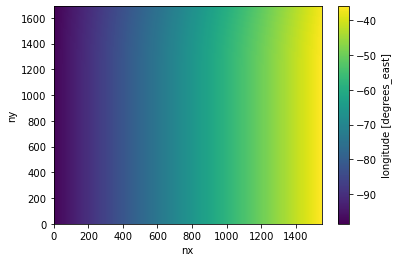

In [24]:
landmask=xr.open_dataset("/Users/james/Documents/Github/esm_lab/grid_gen/gridInfo/nwa25/land_mask.nc")
landmask = landmask.rename({'x': 'lon', 'y': 'lat'})
landmask['lon'].plot()

In [25]:
lon_centers = landmask['lon'].values
lat_centers = landmask['lat'].values

lon_corners = 0.25 * (
    lon_centers[:-1, :-1]
    + lon_centers[1:, :-1]
    + lon_centers[:-1, 1:]
    + lon_centers[1:, 1:]
)

# have to add 2 extra rows/columns to the array becuase we remove 1 when we calculate the corners from the center values
lon_corners2 = np.full((lon_corners.shape[0]+2,lon_corners.shape[1]+2),np.nan)
lon_corners2[:-2,:-2] = lon_corners
lon_corners2

array([[-98.0000129 , -97.96002488, -97.92004449, ..., -36.0999715 ,
                 nan,          nan],
       [-98.0000129 , -97.96002488, -97.92004449, ..., -36.0999715 ,
                 nan,          nan],
       [-98.0000129 , -97.96002488, -97.92004449, ..., -36.0999715 ,
                 nan,          nan],
       ...,
       [-98.44135821, -98.40355913, -98.36576005, ..., -37.20804312,
                 nan,          nan],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan]])

In [26]:
lon_corners2.shape


(1691, 1551)

In [27]:
landmask['lon_b'] = xr.DataArray(data=lon_corners2, dims=("nyp", "nxp"))

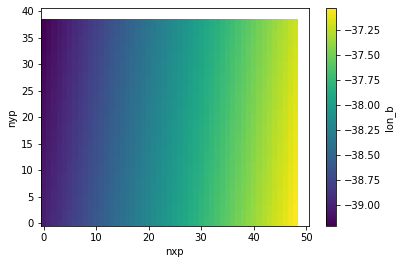

In [28]:
landmask.lon_b.isel(nyp=slice(1650,len(landmask.nyp)), nxp=slice(1500,len(landmask.nxp))).plot()

In [29]:
lon_b = landmask.lon_b
filled = lon_b.interpolate_na(dim='nyp',method='linear',fill_value="extrapolate")

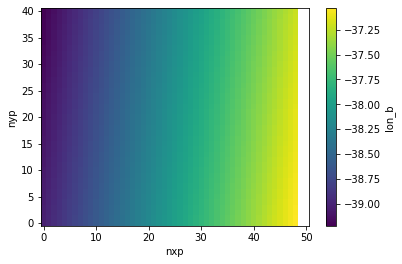

In [30]:
filled.isel(nyp=slice(1650,len(landmask.nyp)), nxp=slice(1500,len(landmask.nxp))).plot()

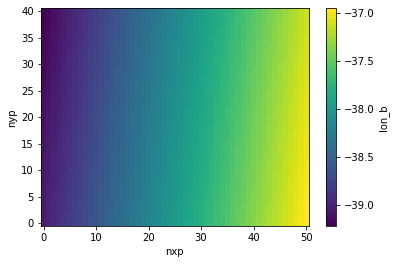

In [31]:
filled_lon = filled.interpolate_na(dim='nxp',method='linear',fill_value="extrapolate")
filled_lon.isel(nyp=slice(1650,len(landmask.nyp)), nxp=slice(1500,len(landmask.nxp))).plot()

In [32]:
lat_corners = 0.25 * (
    lat_centers[:-1, :-1]
    + lat_centers[1:, :-1]
    + lat_centers[:-1, 1:]
    + lat_centers[1:, 1:]
)

lat_corners2 = np.full((lat_corners.shape[0]+2,lat_corners.shape[1]+2),np.nan)
lat_corners2[:-2,:-2] = lat_corners
lat_corners2


array([[ 5.2725295 ,  5.2725295 ,  5.2725295 , ...,  5.2725295 ,
                nan,         nan],
       [ 5.31234722,  5.31234722,  5.31234722, ...,  5.31234722,
                nan,         nan],
       [ 5.35216243,  5.35216243,  5.35216243, ...,  5.35216243,
                nan,         nan],
       ...,
       [48.76348653, 48.77216694, 48.78084593, ..., 58.1490774 ,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]])

In [33]:
lat_corners2.shape

(1691, 1551)

In [34]:
landmask['lat_b'] = xr.DataArray(data=lat_corners2, dims=("nyp", "nxp"))

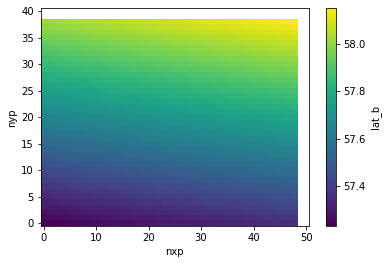

In [35]:
landmask.lat_b.isel(nyp=slice(1650,len(landmask.nyp)), nxp=slice(1500,len(landmask.nxp))).plot()

In [36]:
lat_b = landmask.lat_b
filled= lat_b.interpolate_na(dim='nyp',method='linear',fill_value="extrapolate")

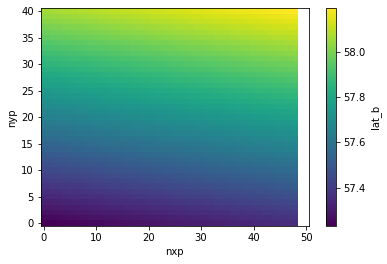

In [37]:
filled.isel(nyp=slice(1650,len(landmask.nyp)), nxp=slice(1500,len(landmask.nxp))).plot()

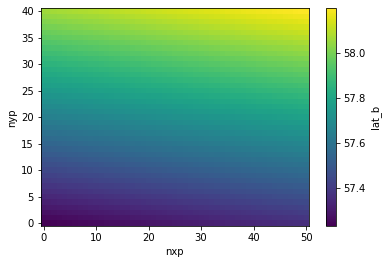

In [38]:
filled_lat = filled.interpolate_na(dim='nxp',method='linear',fill_value="extrapolate")
filled_lat.isel(nyp=slice(1650,len(landmask.nyp)), nxp=slice(1500,len(landmask.nxp))).plot()

In [39]:
landmask['lon_b'] = filled_lon
landmask['lat_b'] = filled_lat

In [40]:
landmask

<xarray.Dataset>
Dimensions:  (nx: 1550, nxp: 1551, ny: 1690, nyp: 1691)
Dimensions without coordinates: nx, nxp, ny, nyp
Data variables:
    mask     (ny, nx) int64 ...
    lon      (ny, nx) float64 -98.02 -97.98 -97.94 ... -37.27 -37.23 -37.19
    lat      (ny, nx) float64 5.253 5.253 5.253 5.253 ... 58.16 58.16 58.16
    lon_b    (nyp, nxp) float64 -98.0 -97.96 -97.92 ... -37.22 -37.18 -37.13
    lat_b    (nyp, nxp) float64 5.273 5.273 5.273 5.273 ... 58.19 58.19 58.2
Attributes:
    grid_version:  0.2
    code_version:  ESMG/gridtools: ['heads/main-0-gf0335a3582-dirty', '']
    history:       2022-01-21: gridtools.grid.mom6.convert_ROMS_to_MOM6 + kwargs

In [120]:
main_era = xr.open_dataset("/Users/james/Downloads/ERA5_2m_temperature_1996.nc")
era = main_era.isel(longitude=slice(1,len(main_era.longitude)-1), latitude=slice(1,len(main_era.latitude)-1))

main_era

<xarray.Dataset>
Dimensions:    (latitude: 261, longitude: 321, time: 8786)
Coordinates:
  * longitude  (longitude) float32 260.0 260.2 260.5 260.8 ... 339.5 339.8 340.0
  * latitude   (latitude) float32 65.0 64.75 64.5 64.25 ... 0.75 0.5 0.25 0.0
  * time       (time) datetime64[ns] 1995-12-31T23:00:00 ... 1997-01-01
Data variables:
    t2m        (latitude, longitude, time) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-06-01 20:46:39 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

In [121]:
era

<xarray.Dataset>
Dimensions:    (latitude: 259, longitude: 319, time: 8786)
Coordinates:
  * longitude  (longitude) float32 260.2 260.5 260.8 261.0 ... 339.2 339.5 339.8
  * latitude   (latitude) float32 64.75 64.5 64.25 64.0 ... 1.0 0.75 0.5 0.25
  * time       (time) datetime64[ns] 1995-12-31T23:00:00 ... 1997-01-01
Data variables:
    t2m        (latitude, longitude, time) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-06-01 20:46:39 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

In [124]:
era = xr.open_dataset("/Users/james/Downloads/ERA5_2m_temperature_1996.nc").sel(longitude=slice(260,330), latitude=slice(65,0))
era = era.rename({'longitude': 'lon', 'latitude': 'lat'})
if "lon" in era.coords:
    era = era.assign_coords(lon=(np.where(era['lon'].values > 180., era['lon'].values - 360, era['lon'].values)))
    era = era.swap_dims({'lon' : 'nx'})    
    era = era.swap_dims({'lat' : 'ny'}) 
if "lon" in era.data_vars:
    era['lon'].values =  np.where(era['lon'].values > 180., era['lon'].values - 360, era['lon'].values)

lon_centers = era['lon'].values
lat_centers = era['lat'].values
# To use conservative regidding, we need the cells corners. 
# Since they are not provided, we are creating some using a crude approximation. 
lon_corners = 0.5 * (
    lon_centers[:-1]
    + lon_centers[1:]
)

lat_corners = 0.5 * (
    lat_centers[:-1]
    + lat_centers[1:]
)

# trim down era by 1 cell
era = era.isel(nx=slice(1,-1), ny=slice(1,-1))

var='t2m'
era_var = np.flipud(era[var])

# add nxp and nyp dimensions for the lat/lon corners to latch onto
era = era.expand_dims({'nyp':(len(era.lat) + 1)})
era = era.expand_dims({'nxp':(len(era.lon) + 1)})

# add the lat/lon corners as data variables
era['lat_corners'] = xr.DataArray(data=np.flipud(lat_corners), dims=("nyp"))
era['lon_corners'] = xr.DataArray(data=lon_corners, dims=("nxp"))
era = era.drop_vars(var)
era['t2m'] = xr.DataArray(data=era_var, dims=("lat", "lon", "time"))

In [130]:
lat_corners


array([64.875, 64.625, 64.375, 64.125, 63.875, 63.625, 63.375, 63.125,
       62.875, 62.625, 62.375, 62.125, 61.875, 61.625, 61.375, 61.125,
       60.875, 60.625, 60.375, 60.125, 59.875, 59.625, 59.375, 59.125,
       58.875, 58.625, 58.375, 58.125, 57.875, 57.625, 57.375, 57.125,
       56.875, 56.625, 56.375, 56.125, 55.875, 55.625, 55.375, 55.125,
       54.875, 54.625, 54.375, 54.125, 53.875, 53.625, 53.375, 53.125,
       52.875, 52.625, 52.375, 52.125, 51.875, 51.625, 51.375, 51.125,
       50.875, 50.625, 50.375, 50.125, 49.875, 49.625, 49.375, 49.125,
       48.875, 48.625, 48.375, 48.125, 47.875, 47.625, 47.375, 47.125,
       46.875, 46.625, 46.375, 46.125, 45.875, 45.625, 45.375, 45.125,
       44.875, 44.625, 44.375, 44.125, 43.875, 43.625, 43.375, 43.125,
       42.875, 42.625, 42.375, 42.125, 41.875, 41.625, 41.375, 41.125,
       40.875, 40.625, 40.375, 40.125, 39.875, 39.625, 39.375, 39.125,
       38.875, 38.625, 38.375, 38.125, 37.875, 37.625, 37.375, 37.125,
      

In [126]:
lon2d, lat2d = np.meshgrid(era.lon.values, np.flipud(era.lat.values))
lon2d_b, lat2d_b = np.meshgrid(era.lon_corners.values, era.lat_corners.values)

In [131]:
lat2d_b

array([[ 0.125,  0.125,  0.125, ...,  0.125,  0.125,  0.125],
       [ 0.375,  0.375,  0.375, ...,  0.375,  0.375,  0.375],
       [ 0.625,  0.625,  0.625, ...,  0.625,  0.625,  0.625],
       ...,
       [64.375, 64.375, 64.375, ..., 64.375, 64.375, 64.375],
       [64.625, 64.625, 64.625, ..., 64.625, 64.625, 64.625],
       [64.875, 64.875, 64.875, ..., 64.875, 64.875, 64.875]],
      dtype=float32)

In [127]:
era = era.assign_coords({"lon" : (("ny", "nx"), lon2d)})
era = era.assign_coords({"lat" : (("ny", "nx"), lat2d)})
era = era.assign_coords({"lon_b" : (("nyp", "nxp"), lon2d_b)})
era = era.assign_coords({"lat_b" : (("nyp", "nxp"), lat2d_b)})

In [132]:
era

<xarray.Dataset>
Dimensions:      (lat: 259, lon: 279, nx: 279, nxp: 280, ny: 259, nyp: 260, time: 8786)
Coordinates:
  * time         (time) datetime64[ns] 1995-12-31T23:00:00 ... 1997-01-01
    lon          (ny, nx) float32 -99.75 -99.5 -99.25 ... -30.75 -30.5 -30.25
    lat          (ny, nx) float32 0.25 0.25 0.25 0.25 ... 64.75 64.75 64.75
    lon_b        (nyp, nxp) float32 -99.88 -99.62 -99.38 ... -30.38 -30.12
    lat_b        (nyp, nxp) float32 0.125 0.125 0.125 ... 64.88 64.88 64.88
Dimensions without coordinates: nx, nxp, ny, nyp
Data variables:
    lat_corners  (nyp) float32 0.125 0.375 0.625 0.875 ... 64.38 64.62 64.88
    lon_corners  (nxp) float32 -99.88 -99.62 -99.38 ... -30.62 -30.38 -30.12
    t2m          (lat, lon, time) float32 295.7 295.7 295.7 ... 277.7 277.6
Attributes:
    Conventions:  CF-1.6
    history:      2020-06-01 20:46:39 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

In [133]:
landmask

<xarray.Dataset>
Dimensions:  (nx: 1550, nxp: 1551, ny: 1690, nyp: 1691)
Dimensions without coordinates: nx, nxp, ny, nyp
Data variables:
    mask     (ny, nx) float64 nan nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    lon      (ny, nx) float64 -98.02 -97.98 -97.94 ... -37.27 -37.23 -37.19
    lat      (ny, nx) float64 5.253 5.253 5.253 5.253 ... 58.16 58.16 58.16
    lon_b    (nyp, nxp) float64 -98.0 -97.96 -97.92 ... -37.22 -37.18 -37.13
    lat_b    (nyp, nxp) float64 5.273 5.273 5.273 5.273 ... 58.19 58.19 58.2
Attributes:
    grid_version:  0.2
    code_version:  ESMG/gridtools: ['heads/main-0-gf0335a3582-dirty', '']
    history:       2022-01-21: gridtools.grid.mom6.convert_ROMS_to_MOM6 + kwargs

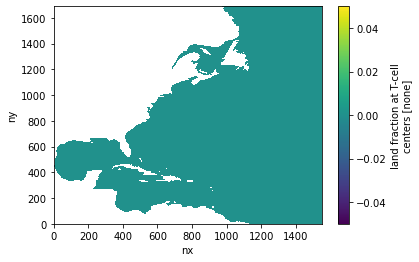

In [134]:
b = landmask
b.mask.plot()

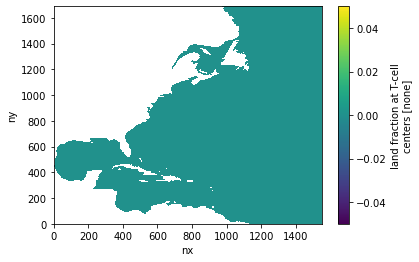

In [135]:
b['mask'] = b['mask'].where(b['mask'] != 1)
b.mask.plot()

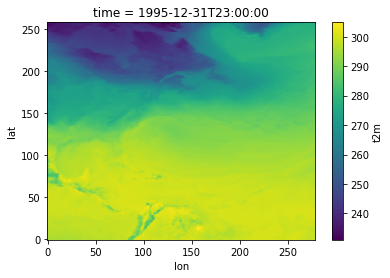

In [136]:
era.t2m.isel(time=0).plot()

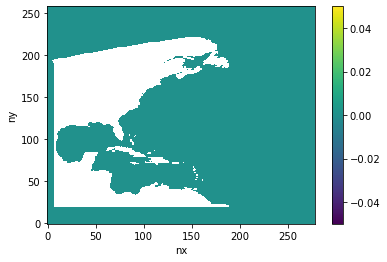

In [137]:
# conservative does the best, especially along fine points
regrid_domain = xesmf.Regridder(b, era, 'conservative', 
                                periodic=False, filename='regrid_domain.nc')



land_regrid = regrid_domain(landmask.mask)
land_regrid.plot()

In [138]:
# Mask Out Hudson Bay
northwest = land_regrid
for y in range(210,len(era.ny)):
    for x in range(0,150):
        if y > 210 and x < 150:
            northwest[y,x] = np.nan

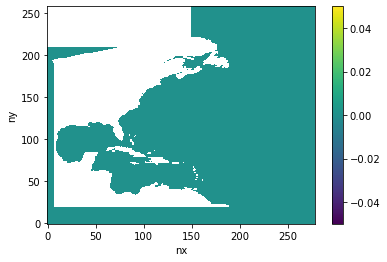

In [139]:
land_regrid.plot()

In [140]:
# Mask Out Hudson Bay
northwest = land_regrid
for y in range(180,len(era.ny)):
    for x in range(0,150):
        if y > 180 and x < 100:
            northwest[y,x] = np.nan

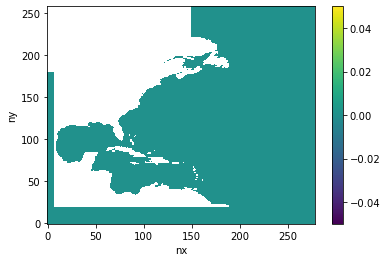

In [141]:
land_regrid.plot()

In [142]:
# Mask Out Hudson Bay
northwest = land_regrid
for y in range(0,len(era.ny)):
    for x in range(0,150):
        if y > 0 and x < 10:
            northwest[y,x] = np.nan

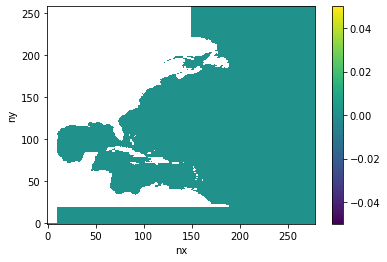

In [143]:
land_regrid.plot()

In [144]:
# Mask Out Hudson Bay
northwest = land_regrid
for y in range(0,20):
    for x in range(0,180):
        if y <20 and x > 0:
            northwest[y,x] = np.nan

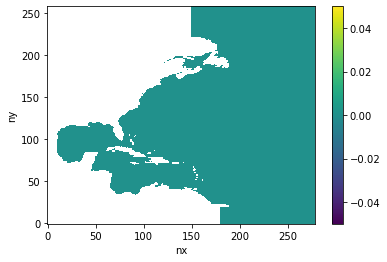

In [145]:
land_regrid.plot()

In [56]:
land_regrid

<xarray.DataArray (ny: 259, nx: 279)>
array([[ 0., nan, nan, ...,  0.,  0.,  0.],
       [nan, nan, nan, ...,  0.,  0.,  0.],
       [nan, nan, nan, ...,  0.,  0.,  0.],
       ...,
       [nan, nan, nan, ...,  0.,  0.,  0.],
       [nan, nan, nan, ...,  0.,  0.,  0.],
       [nan, nan, nan, ...,  0.,  0.,  0.]])
Coordinates:
    lon      (ny, nx) float32 -99.75 -99.5 -99.25 -99.0 ... -30.75 -30.5 -30.25
    lat      (ny, nx) float32 0.25 0.25 0.25 0.25 ... 64.75 64.75 64.75 64.75
Dimensions without coordinates: ny, nx
Attributes:
    regrid_method:  conservative

In [59]:
era['time']

<xarray.DataArray 'time' (time: 8786)>
array(['1995-12-31T23:00:00.000000000', '1996-01-01T00:00:00.000000000',
       '1996-01-01T01:00:00.000000000', ..., '1996-12-31T22:00:00.000000000',
       '1996-12-31T23:00:00.000000000', '1997-01-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1995-12-31T23:00:00 1996-01-01 ... 1997-01-01

In [92]:
ds2 = land_regrid.expand_dims(time=era['time'])

ds2.transpose("time", "ny", "nx")

<xarray.DataArray (time: 8786, ny: 259, nx: 279)>
array([[[ 0., nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        ...,
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.]],

       [[ 0., nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        ...,
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.]],

       [[ 0., nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        ...,
...
        ...,
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.]],

       [[ 0., nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        ...,
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.]],

       [[ 0., nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        ...,
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.]]])
Coordinates:
  * time     (time) datetime64[ns] 1995-12-31T23:00:00 1996-01-01 ... 1997-01-01
    lon      (ny, nx) float32 -99.75 -99.5 -99.25 -99.0 ... -30.75 -30.5 -30.25
    lat      (ny, nx) float32 0.25 0.25 0.25 0.25 ... 64.75 64.75 64.75 64.75
Dimensions without coordinates: ny, nx
Attributes:
    regrid_method:  conservative

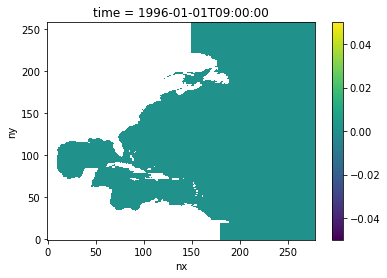

In [75]:
ds2[10].plot()

In [77]:
era=era.transpose("time", "lat", "lon", "nx", "ny", "nxp", "nyp")
era

<xarray.Dataset>
Dimensions:      (lat: 259, lon: 279, nx: 279, nxp: 280, ny: 259, nyp: 260, time: 8786)
Coordinates:
  * time         (time) datetime64[ns] 1995-12-31T23:00:00 ... 1997-01-01
    lon          (nx, ny) float32 -99.75 -99.75 -99.75 ... -30.25 -30.25 -30.25
    lat          (nx, ny) float32 0.25 0.5 0.75 1.0 ... 64.0 64.25 64.5 64.75
    lon_b        (nxp, nyp) float32 -99.88 -99.88 -99.88 ... -30.12 -30.12
    lat_b        (nxp, nyp) float32 0.125 0.375 0.625 ... 64.38 64.62 64.88
Dimensions without coordinates: nx, nxp, ny, nyp
Data variables:
    lat_corners  (nyp) float32 0.125 0.375 0.625 0.875 ... 64.38 64.62 64.88
    lon_corners  (nxp) float32 -99.88 -99.62 -99.38 ... -30.62 -30.38 -30.12
    t2m          (time, lat, lon) float32 295.7 295.7 295.7 ... 277.5 277.6
Attributes:
    Conventions:  CF-1.6
    history:      2020-06-01 20:46:39 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

# Use land_regrid to NaN out land points

In [78]:
era_cut = era['t2m'].where(ds2.values == 0)

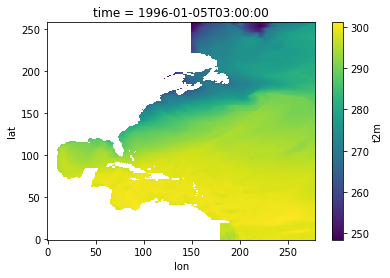

In [80]:
era_cut[100].plot()

In [81]:
from HCtFlood import kara as flood

flood = flood.flood_kara(era_cut)

In [82]:
flood

,Array,Chunk
Bytes,2.37 GiB,282.27 kiB
Shape,"(8786, 1, 259, 279)","(1, 1, 259, 279)"
Count,8786 Tasks,8786 Chunks
Type,float32,numpy.ndarray


In [91]:
flood.isel(z=0).drop('z')

<xarray.DataArray 't2m' (time: 8786, lat: 259, lon: 279)>
dask.array<getitem, shape=(8786, 259, 279), dtype=float32, chunksize=(1, 259, 279), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1995-12-31T23:00:00 1996-01-01 ... 1997-01-01
  * lat      (lat) int64 0 1 2 3 4 5 6 7 8 ... 251 252 253 254 255 256 257 258
  * lon      (lon) int64 0 1 2 3 4 5 6 7 8 ... 271 272 273 274 275 276 277 278

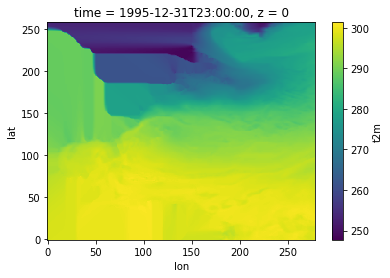

In [83]:
flood[0][0].plot()

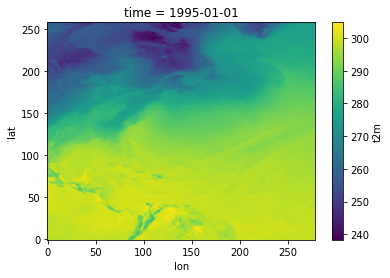

In [139]:
era.t2m.plot()

In [133]:
diff = flood[0][0] - era['t2m'].values

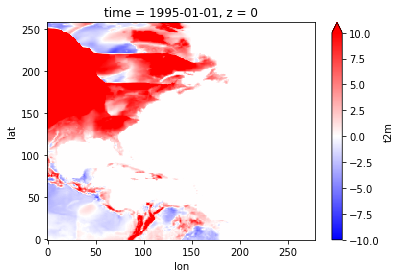

In [137]:
diff.plot(vmin=-10,vmax=10, cmap='bwr')

In [95]:
era = xr.open_dataset("/Users/james/Downloads/ERA5_sea_surface_temperature_1996.nc")
era

<xarray.Dataset>
Dimensions:    (lat: 259, latitude: 261, lon: 279, longitude: 281, time: 8786)
Coordinates:
  * longitude  (longitude) float32 260.0 260.2 260.5 260.8 ... 329.5 329.8 330.0
  * latitude   (latitude) float32 65.0 64.75 64.5 64.25 ... 0.75 0.5 0.25 0.0
  * time       (time) datetime64[ns] 1995-12-31T23:00:00 ... 1997-01-01
  * lat        (lat) int32 0 1 2 3 4 5 6 7 8 ... 251 252 253 254 255 256 257 258
  * lon        (lon) int32 0 1 2 3 4 5 6 7 8 ... 271 272 273 274 275 276 277 278
Data variables:
    sst        (time, lat, lon) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-06-08 09:05:00 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

In [1]:
import numpy as np
import xarray as xr
import xesmf
# https://github.com/raphaeldussin/HCtFlood
from HCtFlood import kara as flood
import sys
import numpy as np
import xarray
import os.path

era5_dict = {'ERA5_2m_temperature':'t2m',
             'ERA5_sea_ice_cover':'siconc',
            'ERA5_10m_u_component_of_wind':'u10',
            'ERA5_sea_surface_temperature':'sst',
            'ERA5_10m_v_component_of_wind':'v10',
            'ERA5_surface_solar_radiation_downwards':'ssrd',
            'ERA5_surface_thermal_radiation_downwards':'strd',
            'ERA5_total_rain_rate':'trr',
            'ERA5_mean_sea_level_pressure':'msl',
            'ERA5_2m_specific_humidity':'q2'}

def interp_landmask(landmask_file):
    landmask = xr.open_dataset(landmask_file).rename({'x': 'lon', 'y': 'lat'})
    lon_centers = landmask['lon'].values
    lat_centers = landmask['lat'].values

    lon_corners = 0.25 * (
        lon_centers[:-1, :-1]
        + lon_centers[1:, :-1]
        + lon_centers[:-1, 1:]
        + lon_centers[1:, 1:]
    )

    # have to add 2 extra rows/columns to the array becuase we remove 1 when we calculate the corners from the center values
    lon_corners_exp = np.full((lon_corners.shape[0]+2,lon_corners.shape[1]+2),np.nan)
    lon_corners_exp[:-2,:-2] = lon_corners
    landmask['lon_b'] = xr.DataArray(data=lon_corners_exp, dims=("nyp", "nxp"))
    lon_b = landmask['lon_b']
    filled = lon_b.interpolate_na(dim='nyp',method='linear',fill_value="extrapolate")
    filled_lon = filled.interpolate_na(dim='nxp',method='linear',fill_value="extrapolate")
    
    # interpolate latitidue corners from latitude cell centers
    lat_corners = 0.25 * (
        lat_centers[:-1, :-1]
        + lat_centers[1:, :-1]
        + lat_centers[:-1, 1:]
        + lat_centers[1:, 1:]
    )

    # create expanded latitude corners array and then interpolate the values so our nxp, nyp = nx+1, ny+1
    lat_corners_exp = np.full((lat_corners.shape[0]+2,lat_corners.shape[1]+2),np.nan)
    lat_corners_exp[:-2,:-2] = lat_corners
    landmask['lat_b'] = xr.DataArray(data=lat_corners_exp, dims=("nyp", "nxp"))
    lat_b = landmask['lat_b']
    filled= lat_b.interpolate_na(dim='nyp',method='linear',fill_value="extrapolate")
    filled_lat = filled.interpolate_na(dim='nxp',method='linear',fill_value="extrapolate")
    landmask['lon_b'] = filled_lon
    landmask['lat_b'] = filled_lat
    landmask['mask'] = landmask['mask'].where(landmask['mask'] != 1)
    
    return landmask
    
    
def interp_era5(era5_file, era5_var):
    era = xr.open_dataset(era5_file)
    era = era.rename({'longitude': 'lon', 'latitude': 'lat'})
    if "lon" in era.coords:
        era = era.assign_coords(lon=(np.where(era['lon'].values > 180., era['lon'].values - 360, era['lon'].values)))
        era = era.swap_dims({'lon' : 'nx'})    
        era = era.swap_dims({'lat' : 'ny'}) 
    if "lon" in era.data_vars:
        era['lon'].values =  np.where(era['lon'].values > 180., era['lon'].values - 360, era['lon'].values)

    lon_centers = era['lon'].values
    lat_centers = era['lat'].values
    # To use conservative regidding, we need the cells corners. 
    # Since they are not provided, we are creating some using a crude approximation. 
    lon_corners = 0.25 * (
        lon_centers[:-1]
        + lon_centers[1:]
        + lon_centers[:-1]
        + lon_centers[1:]
    )

    lat_corners = 0.25 * (
        lat_centers[:-1]
        + lat_centers[1:]
        + lat_centers[:-1]
        + lat_centers[1:]
    )

    # trim down era by 1 cell
    era = era.isel(nx=slice(1,-1), ny=slice(1,-1))
    # era file comes in upside down, we need to flip this
    lat_corners = np.flipud(lat_corners)
    era['lat'] = np.flipud(era['lat'])
    era_flip = np.flipud(era[era5_var])

    # add nxp and nyp dimensions for the lat/lon corners to latch onto
    era = era.expand_dims({'nyp':(len(era.lat) + 1)})
    era = era.expand_dims({'nxp':(len(era.lon) + 1)})

    # add the lat/lon corners as data variables, flip latitude rightside up
    era['lat_corners'] = xr.DataArray(data=lat_corners, dims=("nyp"))
    era['lon_corners'] = xr.DataArray(data=lon_corners, dims=("nxp"))
    # drop the variable
    era = era.drop_vars(era5_var)
    # add the variable back, this time rightside up
    era[era5_var] = xr.DataArray(data=era_flip, dims=("lat", "lon", "time"))
    
    # create meshgrids for center and corner points so we can co-locate with landmask meshgrids.
    lon2d, lat2d = np.meshgrid(era.lon.values, era.lat.values)
    lon2d_b, lat2d_b = np.meshgrid(era.lon_corners.values, era.lat_corners.values)
    
    # assign coordinates now that we have our corner points
    era = era.assign_coords({"lon" : (("ny", "nx"), lon2d)})
    era = era.assign_coords({"lat" : (("ny", "nx"), lat2d)})
    era = era.assign_coords({"lon_b" : (("nyp", "nxp"), lon2d_b)})
    era = era.assign_coords({"lat_b" : (("nyp", "nxp"), lat2d_b)})
    
    return era


In [11]:
landmask_file="/Users/james/Documents/Github/esm_lab/grid_gen/gridInfo/nwa25/land_mask.nc"
era5_file="/Users/james/Downloads/ERA5_2m_temperature_1996.nc"
era5_var="t2m"


landmask = interp_landmask(landmask_file)

#interp era
era = interp_era5(era5_file, era5_var)

# regrid conservatively: conservative does the best, especially along fine points
regrid_domain = xesmf.Regridder(landmask, era, 'conservative', 
                                periodic=False, reuse_weights=False, filename='regrid_domain.nc')
land_regrid = regrid_domain(landmask.mask)
land_regrid=land_regrid.expand_dims(time=era['time'])
land_regrid=land_regrid.transpose("time", "ny", "nx")
#print(land_regrid)
era=era.transpose("time", "lat", "lon", "ny", "nx", "nyp", "nxp")
# cut era based on regridded landmask
era_cut = era[era5_var].where(land_regrid.values == 0)

# flood our cut out points
flooded = flood.flood_kara(era_cut)
flooded = flooded.isel(z=0).drop('z')
#print(flooded)
# note that this current version of this code will cut down your era5 domain by 2 rows/colse)
era = xr.open_dataset(era5_file)
era = era.isel(longitude=slice(1,len(era.longitude)-1), latitude=slice(1,len(era.latitude)-1))
era=era.transpose("time", "latitude", "longitude")
era['latitude'] = np.flipud(era['latitude'])
#fprint(era)
era[era5_var].values = flooded.values




In [9]:
era[era5_var] = flooded

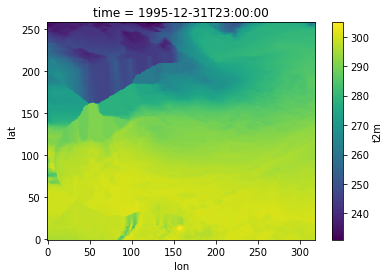

In [10]:
era.t2m[0].plot()